In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tqdm import tqdm
import os
from matplotlib import pyplot as plt

/Users/louiskrause/neuefische/Respiratory_Disease_Classification/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### load dataset from directory

In [2]:
batch_size = 32
IMG_SIZE = (160, 160)

train_dir = 'data/images/cls_2/train'

train_dir = 'data/images_balanced/train'

train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=42,
  image_size=IMG_SIZE,
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
train_dir,
validation_split=0.2,
subset="validation",
seed=42,
image_size=IMG_SIZE,
batch_size=batch_size)

file_paths = val_ds.file_paths
print(file_paths)

#test_dir = 'data/images/cls_2/test'
#test dataset
# test_ds = tf.keras.utils.image_dataset_from_directory(
# test_dir,
# image_size=IMG_SIZE,
# batch_size=batch_size)

Found 747 files belonging to 2 classes.
Using 598 files for training.
Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB

Found 747 files belonging to 2 classes.
Using 149 files for validation.
['data/images_balanced/train/health_1/1_f99_5197.png', 'data/images_balanced/train/health_1/1_f94_5133.png', 'data/images_balanced/train/health_1/1_f93_5124.png', 'data/images_balanced/train/health_1/1_f83_5013.png', 'data/images_balanced/train/health_1/1_f84_5034.png', 'data/images_balanced/train/health_0/0_f20_4317.png', 'data/images_balanced/train/health_0/0_f67_4789.png', 'data/images_balanced/train/health_0/0_f44_4548.png', 'data/images_balanced/train/health_1/1_f75_4902.png', 'data/images_balanced/train/health_0/0_f11_4229.png', 'data/images_balanced/train/health_1/1_f81_4977.png', 'data/images_balanced/train/health_0/0_f47_4572.png', 'data/images_balanced/train/health_1/1_f95_5138.png', 'data/images_balanced/train/health_1/1_f93_5125.png', 'data/images_balanc

2022-11-14 12:59:16.246515: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-14 12:59:16.246692: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Image Preview

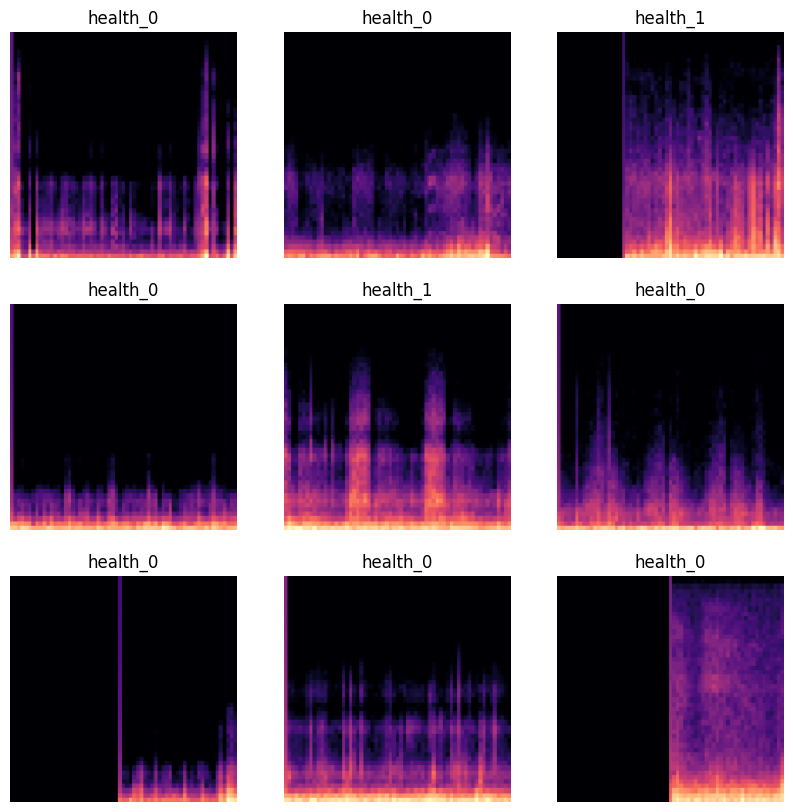

In [4]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(5):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Configure the dataset for performance

In [5]:
AUTOTUNE = tf.data.AUTOTUNE #find a good allocation of CPU budget automatically

#use buffered prefetching, to yield data from disk without having I/O become blocking
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Data Augmentation

In [6]:

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

### Rescale pixel values

In [7]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

### Create the base model from the pre-trained ResNet50

In [8]:
# Create the base model from the pre-trained model ResNet50V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet50V2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

#### Freeze the convolutional base

In [9]:
base_model.trainable = False

### Basemodel summary

In [10]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 166, 166, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 80, 80, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 82, 82, 64)   0           ['conv1_conv[0][0]']    

### Add a classification head

In [11]:
# converts the features (output of base model) to a single 1280-element vector per image
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

### Add Dense Layer

In [12]:
#No activation Function needed because positive numbers predict class 1, negative numbers predict class 0
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')

### Build a model

In [13]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = rescale(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

In [14]:
#Compile the model before training it. Since there are two classes,
#use tf.keras.losses.BinaryCrossentropy loss with from_logits=True since the model provides a linear output.
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 160, 160, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 5, 5, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

### Train the model

In [16]:
initial_epochs = 25

loss0, accuracy0 = model.evaluate(val_ds)

2022-11-14 13:00:47.744652: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 1s 108ms/step - loss: 0.8566 - accuracy: 0.4430


In [17]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.86
initial accuracy: 0.44


In [18]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/25


2022-11-14 13:00:58.318802: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 4s 114ms/step - loss: 1.0021 - accuracy: 0.4298 - val_loss: 0.7594 - val_accuracy: 0.5101
Epoch 2/25
19/19 [==============================] - 2s 102ms/step - loss: 0.8656 - accuracy: 0.4833 - val_loss: 0.7297 - val_accuracy: 0.4899
Epoch 3/25
19/19 [==============================] - 2s 102ms/step - loss: 0.8255 - accuracy: 0.4950 - val_loss: 0.7158 - val_accuracy: 0.5168
Epoch 4/25
19/19 [==============================] - 2s 102ms/step - loss: 0.7627 - accuracy: 0.5485 - val_loss: 0.7063 - val_accuracy: 0.5436
Epoch 5/25
19/19 [==============================] - 2s 103ms/step - loss: 0.8175 - accuracy: 0.5368 - val_loss: 0.6964 - val_accuracy: 0.5570
Epoch 6/25
19/19 [==============================] - 2s 102ms/step - loss: 0.7519 - accuracy: 0.5719 - val_loss: 0.6887 - val_accuracy: 0.5638
Epoch 7/25
19/19 [==============================] - 2s 102ms/step - loss: 0.7151 - accuracy: 0.6003 - val_loss: 0.6818 - val_accuracy: 0.5705
Epoch 8/25
19/19 

### Learning Curves

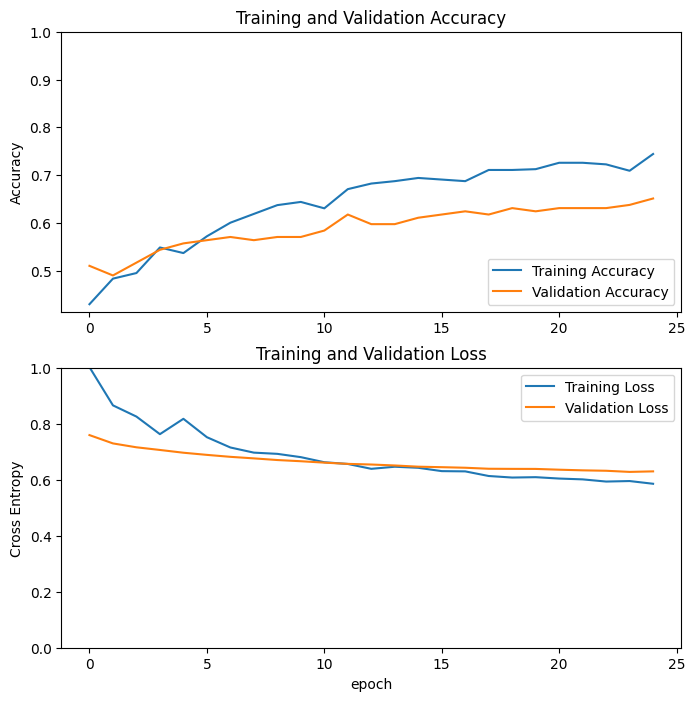

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#Note: If you are wondering why the validation metrics are clearly better than the training metrics,
#the main factor is because layers like tf.keras.layers.BatchNormalization and tf.keras.layers.Dropout
#affect accuracy during training. They are turned off when calculating validation loss.

In [20]:
y_pred = model.predict(val_ds)

2022-11-14 13:02:22.679248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [21]:
y = np.concatenate([y for x, y in val_ds], axis=0)
y

array([0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1], dtype=int32)

In [22]:
y_pred.shape

(149, 1)

In [23]:
len(file_paths)

149

In [24]:
import re 

lst = [re.findall('[fi]\d{1,3}',x)[0] for x in file_paths]
len(lst)

149

In [25]:
lst.sort()
lst

['f1',
 'f1',
 'f100',
 'f100',
 'f100',
 'f102',
 'f102',
 'f103',
 'f104',
 'f105',
 'f108',
 'f108',
 'f109',
 'f11',
 'f11',
 'f11',
 'f11',
 'f110',
 'f110',
 'f112',
 'f12',
 'f14',
 'f16',
 'f18',
 'f18',
 'f19',
 'f2',
 'f2',
 'f20',
 'f21',
 'f22',
 'f28',
 'f28',
 'f29',
 'f29',
 'f3',
 'f3',
 'f31',
 'f31',
 'f36',
 'f39',
 'f39',
 'f43',
 'f44',
 'f44',
 'f45',
 'f46',
 'f47',
 'f48',
 'f48',
 'f48',
 'f48',
 'f49',
 'f49',
 'f49',
 'f50',
 'f50',
 'f50',
 'f50',
 'f52',
 'f54',
 'f55',
 'f58',
 'f58',
 'f58',
 'f58',
 'f61',
 'f62',
 'f62',
 'f65',
 'f67',
 'f67',
 'f67',
 'f67',
 'f68',
 'f68',
 'f70',
 'f71',
 'f72',
 'f72',
 'f72',
 'f73',
 'f73',
 'f73',
 'f73',
 'f75',
 'f75',
 'f78',
 'f78',
 'f79',
 'f79',
 'f81',
 'f81',
 'f82',
 'f83',
 'f83',
 'f84',
 'f84',
 'f84',
 'f84',
 'f84',
 'f84',
 'f84',
 'f84',
 'f84',
 'f84',
 'f86',
 'f87',
 'f88',
 'f88',
 'f9',
 'f9',
 'f90',
 'f90',
 'f93',
 'f93',
 'f94',
 'f94',
 'f95',
 'f96',
 'f96',
 'f97',
 'f98',
 'f99',
 '

### Fine tuning

Read before you go on:

This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.